# TECHINCAL TREND CRAWLING CODE FOR CGBIO 
# 시지바이오 주요기사 크롤링 코드
## 1. CRAWLING (Article in Naver/네이버뉴스기사, Google Scholar publications/구글 스칼라 논문검색)
* 1.1 Summarize the google scholar publications/구글 스칼라 논문 정리 (Recent 최신순, Citation 인용순)
* 1.2 

<br>

## 2. Summarize the data and setting the framework / 데이터 정리 및 프레임 설정
* 2.1 Remove the outlier and set the number of data / 데이터 보여줄 개수 및 이상치 제외
* 2.2 Merge Data: Integrate into structured framework /  데이터 통합: 각 데이터를 정형화된 틀로 통합(DB화)

<br>

[KEYWORD FOR RESEARCH TEAM NUMBER 6]  
* Below keywords are seperated with comma
* 기술 Techincal keywords : hemocompatible coating, Very late thrombosis, thin strut, Scaffold coverage, PCI, Compliance, Scaffold
* 제품 Product keywords : Bioresorbable Vascular Stent, Poly L-lacticacid, OTW Balloon, suction catheter, delivery system, Balloon catheterDES, DEB
* 기타 ETC : AI medical device


## **TODO list**
<input type="checkbox" checked> Parse proxy list \
<input type="checkbox" checked> Avoid google detection and CAPTCHA page dynamically \
<input type="checkbox" checked>  Fix citations with different languages since they depend on proxy location \
<input type="checkbox" checked > Source links are more than expected at times - this screws up the "Source" column, so be careful about it \
(<input type="checkbox" checked >) [It worked before the code fixing, now it has some bug - to be fixed!] Use multi-threading / multi-processing to speed up the huge for loop ~~(currently it takes >4 hours)~~ with this less than 30 minutes! \
(<input type="checkbox" checked>) Use shared dataframe to improve proxy checking stats and efficiency (does not work in the `multiprocessing` part) \
<input type="checkbox" > Years is sometimes 0 if the publisher contains a "-" (e.g. diva-portal.org) \
<input type="checkbox" > If the word has some problems, such as "Hemocopatible coating" (in this case a misspelling) and Google suggests another one, then the code fucks it up -> either check always that words are correct, or we should make some extra code for fixing this

In [ ]:
import sys
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
from tqdm.notebook import tqdm # notebook version, a bit cooler
from warnings import warn
import multiprocessing # speed up the crawler
from tabulate import tabulate # fancify some stuff
import re

In [ ]:
# Start new session
session = requests.Session()

# Variables
number_of_results = 100 # number of results to look for on Google Scholar
save_database = True # choose if you would like to save the database to .csv
keyword = 'Bioresorbable Vascular Stent'
path = './'+keyword+'_result_cgbio.csv' # path to save the data

links = list()
title = list()
citations = list()
year = list()
rank = list()
author = list()
rank.append(0) # initialization necessary for incremental purposes

In [ ]:
# functions
# def get_citations(content):
#     out = 0
#     for char in range(0,len(content)): 
#         if content[char:char+9] == 'Cited by ': # does not work in other languages depending on proxy location!
#             init = char+9                          
#             for end in range(init+1,init+6):
#                 if content[end] == '<':
#                     break
#             out = content[init:end]
#     return int(out)

def get_citations(content):
    """Parse content with "/scholar?cites, so it works in multiple languages"""
    try:
      item = content.find_all("a", href=lambda href: href and href.startswith("/scholar?cites"))[0]
      if hasattr(item, 'string'):
        # Needed for e.g. Thai language in which there is no space or Chinese in which the counter 次 screws up the count
        citations = item.string.replace(" ", "") 
        citations = int(re.findall(r"\d+", citations)[0])
    except:
      citations = 0 # if citations could not be parsed this is the default return value
    return citations

def get_year(content):
    for char in range(0,len(content)):
      if content[char] == '-':
        out = content[char-5:char-1]
    if not out.isdigit():
        out = 0
    return int(out)

def get_author(content):
    for char in range(0,len(content)):
        if content[char] == '-':
            out = content[2:char-1]
            break
    return out

## Avoiding bot detection by Google

### Proxies
The main method here is to use _proxies_ from https://freeproxylists.net/ \
(another good one here: https://fossbytes.com/free-proxy-list/) \

These sometimes don't work and are not very reliable, here are some better solutions I found:

- [Selenium](https://towardsdatascience.com/web-scraping-using-selenium-python-8a60f4cf40ab): this makes it easier to scrape data and can also use cookies, browser GUI etc (not easy to use on Colab or on headless servers though) to avoid detection
- [Scrapy](https://scrapy.org/) another good library for scraping, but there is need for some `API_KEY` (I think for the proxies that need to be paid)
- [SerpApi](https://serpapi.com/) probably most comprehensive solution, but of course payment is needed here

So, cheap solutions seem free proxy servers and/or `selenium` if we can make them work. If Daewoong has some servers to use as proxy, perhaps we could use them

**[Update]** \
I found out [this beautiful Github repo](https://github.com/monosans/proxy-list) in which proxies are updated automatically based on their responses. Looks like Linus Torvalds (the father of Linux) is contributing himself so... I'll take this as a good sign :) let's scrape from here!




Assuming we don't want to pay a proxy service or so, we can do the following:
1. Obtain page data through working proxy server
2. (prelimary) Scrape the webpage
3. If the webpage contains some keywords saying like "check if you are a robot" or so, then we change the proxy server and restart from point 1
4. Scrape for important data 
5. Save and connect to database and the next steps

## Obtain proxies from updated list

In [ ]:
# Get free proxies
url = "https://raw.githubusercontent.com/monosans/proxy-list/main/proxies_geolocation/http.txt" 
proxies_raw = pd.read_csv(url,  sep="::", names=["Address:port", "Country", "Region", "City"])

# Modify the dataset
# let's remove Chinese servers (CCP blocks access to Scholar too, lol)
proxies = proxies_raw[proxies_raw['Country'] != 'China']
proxies = proxies.assign(Success=0, Blocked=0, Timeout=0) # add extra metrics to the dataframe to get the best server
proxies.reset_index(drop=True, inplace=True)
proxies

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,Address:port,Country,Region,City,Success,Blocked,Timeout
0,1.1.189.58:8080,Thailand,Yasothon,Yasothon,0,0,0
1,1.1.220.100:8080,Thailand,Lampang,Lampang,0,0,0
2,1.10.141.220:54620,Thailand,Phayao,Phayao,0,0,0
3,1.20.99.122:8080,Thailand,None,None,0,0,0
4,1.20.217.52:8080,Thailand,Satun,Satun,0,0,0
...,...,...,...,...,...,...,...
1423,217.218.66.76:80,Iran,None,None,0,0,0
1424,219.83.34.178:8080,Indonesia,West Java,None,0,0,0
1425,222.165.235.2:80,Indonesia,Jakarta,Jakarta,0,0,0
1426,222.165.235.254:80,Indonesia,Jakarta,Jakarta,0,0,0


### Other tricks

Here are some ideas [[Stackoverflow]](https://stackoverflow.com/questions/60535351/web-scraping-google-search-results/60536180#60536180)

- We can start by implementing a time randomizer (drawing values from a uniform distribution)
- Use `headers` a normal user would use (so it's less predictable)


In [ ]:
# Anti-detection utils

timeout = 10 # proxy timeout
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36, 'referer':'https://www.google.com/'}"}

# Function to order proxy reliability
def move_row(df, idx, to='first'):
  """Move dataframe row. Rough implementation, maybe there is a cleaner way
  but this seems to get the job done
  Args:
    df: dataframe
    idx: index of the row
    to: position, either 'first' or 'last'
  """
  size = len(df)
  if idx >= size-1:
    return df # cannot move this one
  else:
    reindexing = np.arange(size)
    if to is 'first':
      reindexing[:idx+1] -= 1
      reindexing[0] = idx
    elif to is 'last':
      reindexing[idx:] += 1
      reindexing[size-1] = idx
    else:
      warn(f'Keyword {to} has no effect for now')
      return df # cannot move this one
    df = df.reindex(reindexing)
    df.reset_index(drop=True, inplace=True)
  return df

# Captcha detection
def detect_captcha(soup):
  """Detect if the webpage (Google in this case) is asking for the Captcha code"""
  # captcha = soup.find("form", id="gs_captcha_f")
  captcha = soup.select('form[id*="captcha"]') # this should recognize every form containing captcha
  if captcha:
    return True
  else:
    return False

# Randomize time with a uniform distribution, we should adjust the times depending on the detection rate
def random_time(low=2.0, high=7.0):
  return np.random.uniform(low=low, high=high, size=None)

# Obtain webpage with some tricks
def proxy_get(url):
  """Iterate over proxy dataframe to obtain a valid webpage
  The function does the following:
    - Check for working pages
    - Check for captcha
    - Change non-working proxies position so they aren't checked again
    - Random sleep to avoid re-detection with same proxy
    - Metrics saving
  Args:
    url: url to search for in string format
    proxies: pandas dataframe containing the proxies

  NOTE: still a rough implementation, some stuff is subject to change. Feedback is welcome :)
  """
  global proxies
  for index, proxy_row in proxies.iterrows():
    proxy = {'https':'https://'+str(proxy_row['Address:port'])}
    try:
      page = session.get(url, proxies=proxy, headers=headers, timeout=timeout) # use proxy to avoid detection
    except:
      # Timeout proxy becomes last in the dataframe, so we don't retry it
      proxies.loc[index, 'Timeout'] += 1 # increase timeouts number
      proxies = move_row(proxies, index, to='last')
      continue
    else:
      c = page.content
      soup = BeautifulSoup(c, 'html.parser') # parser
      if detect_captcha(soup):
        # Proxy with CAPTCHA verification becomes last in the dataframe, so we don't retry it
        proxies.loc[index, 'Blocked'] += 1 # increase blocked number
        proxies = move_row(proxies, index, to='last')
        continue
      else:
        proxies.loc[index, 'Success'] += 1 # increase success number
        break

  # Randomize time between requests
  time.sleep(random_time())
  return soup

## Single Keyword

In [ ]:
# Start new session

keyword = 'Hemocompatible coating'
session = requests.Session()
path = './'+keyword+'_result_cgbio.csv' # path to save the data

links = list()
title = list()
citations = list()
year = list()
rank = list()
author = list()
rank.append(0) # initialization necessary for incremental purposes

for n in tqdm(range(0, number_of_results, 10)):    
    url = 'https://scholar.google.com/scholar?start='+str(n)+'&q='+keyword.replace(' ','+')
    soup = proxy_get(url)

    # Get stuff
    mydivs = soup.findAll("div", { "class" : "gs_r" })
    
    for div in mydivs:
        try:
            links.append(div.find('h3').find('a').get('href'))
        except Exception as e: # catch *all* exceptions
            # If the above fails, we should not append anything or we introduce dummy variables
            # links.append('no link')
            continue 
        try:
            title.append(div.find('h3').find('a').text)
        except: 
            title.append('Could not catch title')
        try:
          year.append(get_year(div.find('div',{'class' : 'gs_a'}).text))
        except:
          year.append(0)
        try:
          author.append(get_author(div.find('div',{'class' : 'gs_a'}).text))
        except:
          author.append('Could not catch author')
        citations.append(get_citations(div))
        rank.append(rank[-1]+1)

print(len(links), len(title), len(citations), len(year), len(author))

  0%|          | 0/10 [00:00<?, ?it/s]

100 100 100 100 100


                                                 Author  ...                                             Source
Rank                                                     ...                                                   
46                     Ellis, DJ Kereiakes, DC Metzger…  ...  https://www.nejm.org/doi/full/10.1056/NEJMoa15...
74        Capodanno, T Gori, H Nef, A Latib, J Mehilli…  ...  https://www.researchgate.net/profile/Davide-Ca...
2     Cassese, RA Byrne, G Ndrepepa, S Kufner, J Wiebe…  ...  https://www.sciencedirect.com/science/article/...
70                    Wykrzykowska, RP Kraak, SH Hofma…  ...  https://www.nejm.org/doi/full/10.1056/NEJMoa16...
4              Gao, Y Yang, Y Han, Y Huo, J Chen, B Yu…  ...  https://www.jacc.org/doi/abs/10.1016/j.jacc.20...
...                                                 ...  ...                                                ...
71                          Shah, M Fatima, AM Dharani…  ...  https://www.tandfonline.com/doi/abs/10.108

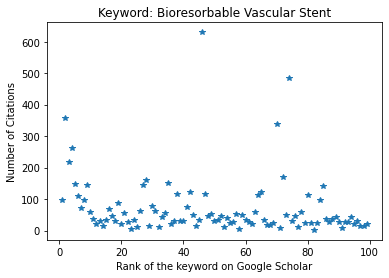

In [ ]:
# Create a dataset and sort by the number of citations
data = pd.DataFrame(zip(author, title, citations, year, links), index = rank[1:], 
                    columns=['Author', 'Title', 'Citations', 'Year', 'Source'])
data.index.name = 'Rank'

data_ranked = data.sort_values('Citations', ascending=False)
print(data_ranked)

# Plot by citation number
plt.plot(rank[1:],citations,'*')
plt.ylabel('Number of Citations')
plt.xlabel('Rank of the keyword on Google Scholar')
plt.title('Keyword: '+keyword)

# Save results
if save_database:
    data_ranked.to_csv(path, encoding='utf-8-sig') # Change the path

## Run code for all the keywords
This is a giant `for` loop, so it will take time\
Unlike the `multiprocessing` one which is faster, this one iterates over all the words one at a time - however, this saves also the best proxies

In [ ]:
# List of keywords to parse
keywords = ['Hemocompatible coating', 'Very late trombosis', 'Thin strut', 'Scaffold coverage', 'PCI', 'Compliance', 'Scaffold', # technical keywords team 6
            'Bioresorbable vascular stent', 'Poly L-lacticacid', 'OTW balloon', 'Suction catheter', 'Delivery system', 'Balloon catheter DES', 'DEB'# product keywords team 6
            'AI medical device','Spine', 'Spinal implant', 'Spinal fusion device', 'Surface treatment', 'Hydrophilic', 'Spinal technology', # technical keywords research team 4
            '3D printing', 'Navigation', 'Innovative', 'Innovation', 'Technologies', 'Platform', 'Development',
            'Digital surgery', 'Guide', 'Image guided', 'Robotic guided',
            'Expendable cage', '3D printing cage', 'VBR', 'Vertical body replacement', 'ADR', 'Artificial disk replacement', # product keywords research team 4
            'TDR', 'Total disc replacement', 'Joint replacement', 'MIS', 'Minimal invasive surgery', 'Percutaneous', 'Pedicle screw',
            'Pediatric screw', 'Deformity surgery', 'Cervical screw', 'Occipital plate', 'ACP',
            'Anterior cervical plate', 'Translation plate',
            'Bio 3D print', 'Bio 3d fabrication', 'Ceramic print', 'AI 3D print', '3D print qc' # product keywords team 10
]


for keyword in tqdm(keywords):
  """Search Google Scholar for keywords and return dataframe"""

  # Start new session
  session = requests.Session()
  path = './'+keyword+'_result_cgbio.csv' # path to save the data

  links = list()
  title = list()
  citations = list()
  year = list()
  rank = list()
  author = list()
  rank.append(0) # initialization necessary for incremental purposes

  for n in tqdm(range(0, number_of_results, 10), desc=f'Searching for {keyword}', leave=True): 
    url = 'https://scholar.google.com/scholar?start='+str(n)+'&q='+keyword.replace(' ','+')
    soup = proxy_get(url)
    # Get stuff
    mydivs = soup.findAll("div", { "class" : "gs_r" })
    
    for div in mydivs:
        try:
            links.append(div.find('h3').find('a').get('href'))
        except Exception as e: # catch *all* exceptions
            # If the above fails, we should not append anything or we introduce dummy variables
            # links.append('no link')
            continue 
        try:
            title.append(div.find('h3').find('a').text)
        except: 
            title.append('Could not catch title')
        try:
          year.append(get_year(div.find('div',{'class' : 'gs_a'}).text))
        except:
          year.append(0)
        try:
          author.append(get_author(div.find('div',{'class' : 'gs_a'}).text))
        except:
          author.append('Could not catch author')
        citations.append(get_citations(div))
        rank.append(rank[-1]+1)

  print(f'Articles crawled for {keyword}: {len(title)}')
  
  # Create a dataset and sort by the number of citations
  data = pd.DataFrame(zip(author, title, citations, year, links), index = rank[1:], 
                      columns=['Author', 'Title', 'Citations', 'Year', 'Source'])
  data.index.name = 'Rank'
  data_ranked = data.sort_values('Citations', ascending=False)
  # Save results
  if save_database:
      data_ranked.to_csv(path, encoding='utf-8-sig') # Change the path 

  0%|          | 0/56 [00:00<?, ?it/s]

Searching for Hemocompatible coating:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Hemocompatible coating: 100


Searching for Very late trombosis:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Very late trombosis: 97


Searching for Thin strut:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Thin strut: 100


Searching for Scaffold coverage:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Scaffold coverage: 100


Searching for PCI:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for PCI: 99


Searching for Compliance:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Compliance: 100


Searching for Scaffold:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Scaffold: 100


Searching for Bioresorbable vascular stent:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Bioresorbable vascular stent: 99


Searching for Poly L-lacticacid:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Poly L-lacticacid: 85


Searching for OTW balloon:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for OTW balloon: 100


Searching for Suction catheter:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Suction catheter: 98


Searching for Delivery system:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Delivery system: 100


Searching for Balloon catheter DES:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Balloon catheter DES: 100


Searching for DEBAI medical device:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for DEBAI medical device: 26


Searching for Spine:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Spine: 97


Searching for Spinal implant:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Spinal implant: 100


Searching for Spinal fusion device:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Spinal fusion device: 100


Searching for Surface treatment:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Surface treatment: 98


Searching for Hydrophilic:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Hydrophilic: 100


Searching for Spinal technology:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Spinal technology: 94


Searching for 3D printing:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for 3D printing: 100


Searching for Navigation:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Navigation: 98


Searching for Innovative:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Innovative: 98


Searching for Innovation:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Innovation: 97


Searching for Technologies:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Technologies: 98


Searching for Platform:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Platform: 99


Searching for Development:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Development: 97


Searching for Digital surgery:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Digital surgery: 99


Searching for Guide:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Guide: 87


Searching for Image guided:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Image guided: 100


Searching for Robotic guided:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Robotic guided: 100


Searching for Expendable cage:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Expendable cage: 94


Searching for 3D printing cage:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for 3D printing cage: 100


Searching for VBR:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for VBR: 100


Searching for Vertical body replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Vertical body replacement: 98


Searching for ADR:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for ADR: 100


Searching for Artificial disk replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Artificial disk replacement: 95


Searching for TDR:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for TDR: 99


Searching for Total disc replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Total disc replacement: 100


Searching for Joint replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Joint replacement: 100


Searching for MIS:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for MIS: 101


Searching for Minimal invasive surgery:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Minimal invasive surgery: 100


Searching for Percutaneous:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Percutaneous: 100


Searching for Pedicle screw:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Pedicle screw: 100


Searching for Pediatric screw:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Pediatric screw: 100


Searching for Deformity surgery:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Deformity surgery: 100


Searching for Cervical screw:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Cervical screw: 100


Searching for Occipital plate:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Occipital plate: 99


Searching for ACP:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for ACP: 100


Searching for Anterior cervical plate:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Anterior cervical plate: 100


Searching for Translation plate:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Translation plate: 99


Searching for Bio 3D print:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Bio 3D print: 98


Searching for Bio 3d fabrication:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Bio 3d fabrication: 100


Searching for Ceramic print:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for Ceramic print: 99


Searching for AI 3D print:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for AI 3D print: 99


Searching for 3D print qc:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled for 3D print qc: 99


In [ ]:
proxies.to_csv('proxies_log.csv', encoding='utf-8-sig') # Change the path 

## [WIP] Run code for all the keywords in parallel with `multiprocessing`



In [ ]:
# # Variables
# number_of_results = 100 # number of results to look for on Google Scholar
# save_database = True # choose if you would like to save the database to .csv

# # List of keywords to parse
# List of keywords to parse
# keywords = ['Hemocompatible coating', 'Very late trombosis', 'Thin strut', 'Scaffold coverage', 'PCI', 'Compliance', 'Scaffold', # technical keywords team 6
#             'Bioresorbable vascular stent', 'Poly L-lacticacid', 'OTW balloon', 'Suction catheter', 'Delivery system', 'Balloon catheterDES', 'DEB'# product keywords team 6
#             'AI medical device','Spine', 'Spinal implant', 'Spinal fusion device', 'Surface treatment', 'Hydrophilic', 'Spinal technology', # technical keywords research team 4
#             '3D printing', 'Navigation', 'Innovative', 'Innovation', 'Technologies', 'Platform', 'Development',
#             'Digital surgery', 'Guide', 'Image guided', 'Robotic guided',
#             'Expendable cage', '3D printing cage', 'VBR', 'Vertical body replacement', 'ADR', 'Artificial disk replacement', # product keywords research team 4
#             'TDR', 'Total disc replacement', 'Joint replacement', 'MIS', 'Minimal invasive surgery', 'Percutaneous', 'Pedicle screw',
#             'Pediatric screw', 'Deformity surgery', 'Cervical screw', 'Occipital plate', 'ACP',
#             'Anterior cervical plate', 'Translation plate',
#             'Bio 3D print', 'Bio 3d fabrication', 'Ceramic print', 'AI 3D print', '3D print qc' # product keywords team 10
# ]


# def search_scholar(keyword, proxies):
#   """Search Google Scholar for keywords and return dataframe"""

#   # Start new session
#   session = requests.Session()
#   path = './'+keyword+'_result_cgbio.csv' # path to save the data

#   links = list()
#   title = list()
#   citations = list()
#   year = list()
#   rank = list()
#   author = list()
#   rank.append(0) # initialization necessary for incremental purposes

#   for n in tqdm(range(0, number_of_results, 10), desc=f'Searching for {keyword}', leave=False): 
#       # Needed to print inside multiprocessing
#       sys.stdout.flush()

#       url = 'https://scholar.google.com/scholar?start='+str(n)+'&q='+keyword.replace(' ','+')
#       soup = proxy_get(url, proxies)

#       # Get stuff
#       mydivs = soup.findAll("div", { "class" : "gs_r" })
      
#       for div in mydivs:
          
#           try:
#               links.append(div.find('h3').find('a').get('href'))
#           except Exception as e: # catch *all* exceptions
#               # If the above fails, we should not append anything or we introduce dummy variables
#               # links.append('no link')
#               continue 

#           try:
#               title.append(div.find('h3').find('a').text)
#           except: 
#               title.append('Could not catch title')
              
#           # citations.append(get_citations(str(div.format_string))) # legacy with old function
#           citations.append(get_citations(div))
#           year.append(get_year(div.find('div',{'class' : 'gs_a'}).text))
#           author.append(get_author(div.find('div',{'class' : 'gs_a'}).text))
#           rank.append(rank[-1]+1)

#   print("="*42 + f'\n{keyword}\nArticles crawled: {len(title)}')
  
#   # Create a dataset and sort by the number of citations
#   data = pd.DataFrame(zip(author, title, citations, year, links), index = rank[1:], 
#                       columns=['Author', 'Title', 'Citations', 'Year', 'Source'])
#   data.index.name = 'Rank'
#   data_ranked = data.sort_values('Citations', ascending=False)
#   # Save results
#   if save_database:
#       data_ranked.to_csv(path, encoding='utf-8-sig') # Change the path 
#   return

# # pool = multiprocessing.Pool()
# # result = list(tqdm(pool.imap(search_scholar, keywords), total=len(keywords)))

# # This should hopefully retain the dataframe among every process (shared memory)
# mgr = multiprocessing.Manager(); ns = mgr.Namespace() 
# ns.df = proxies

# jobs = []
# for keyword in keywords:
#   p = multiprocessing.Process(target=search_scholar, args =(keyword, ns.df))
#   jobs.append(p)
#   p.start()

# for proc in tqdm(jobs):
#   proc.join()

  0%|          | 0/56 [00:00<?, ?it/s]

Process Process-42:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-19-2fa4925a4735>", line 60, in search_scholar
    year.append(get_year(div.find('div',{'class' : 'gs_a'}).text))
AttributeError: 'NoneType' object has no attribute 'text'


Occipital plate
Articles crawled: 99
Technologies
Articles crawled: 49
Very late trombosis
Articles crawled: 30
Development
Articles crawled: 9
Image guided
Articles crawled: 10
Pediatric screw
Articles crawled: 20==========================================
3D printing cage
Articles crawled: 0

Bio 3D print
Articles crawled: 10
Percutaneous
Articles crawled: 0
Bio 3d fabrication
Articles crawled: 0
Anterior cervical plate
Articles crawled: 0
Innovative
Articles crawled: 0
Ceramic print
Articles crawled: 10
Joint replacement
Articles crawled: 10


KeyboardInterrupt: ignored

In [ ]:
# # if you want to astop the code, run this
# for proc in tqdm(jobs):
#   proc.terminate()

There are still some problems, for example:
- **Update** it used to work (before fixing the citations and links) but now for some reasons result get smaller over time in this, so this bug should be fixed
- Some pages crash the process, probably due to a non-detection of the captcha
- It would be nice to see `tqdm` running inside each one
- Some titles are missing
- Some style fixes to the code would be nice

On the bright side, it took only 27 minutes to obtain the data - compared to more than 4 hours before! ^^

___

In [ ]:
## Extra code
# assert False, "Extra code aheaaaad"

In [ ]:
# # let's see where these proxies are from just for fun
# !pip install geopandas
# !pip install geoplot

# import geopandas
# import geoplot

# world = geopandas.read_file(
#     geopandas.datasets.get_path('naturalearth_lowres')
# )
# TODO, not necessary
# geoplot.polyplot(world, figsize=(12, 8))

# headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Cafari/537.36'}


# def get_free_proxies():

#     # Get the HTTP response and construct soup object
#     soup = bs(requests.get(url).content, "html.parser")
#     proxies = []

#     print(soup)
#     print(soup.find("table"))

#     # Collect proxy data 
#     for row in soup.findAll("table")[1].find_all("tr")[1:]:
#         tds = row.find_all("td")
#         try:
#             # obtain information about the proxies
#             ip = tds[0].text.strip()
#             port = tds[1].text.strip()
#             code = tds[2].text.strip()
#             country = tds[3].text.strip()
#             anonimity = tds[4].text.strip()
#             google = tds[5].text.strip()
#             https = tds[6].text.strip()
#             print(ip, port, code, country, anonimity, google)
#             host = f"https://{ip}:{port}" if https is 'yes' else  f"http://{ip}:{port}"
#             protocol = "https" if https is 'yes' else  "http"
#             proxies.append({protocol:'host', })

#         except IndexError:
#             continue
#     return proxies

# proxies = get_free_proxies()

# print(proxies)